In [1]:
import dotenv
import os 

dotenv.load_dotenv("azure.env")

True

In [2]:
import base64
from PIL import Image

def open_image_to_base64(file_path):
    with open(file_path, "rb") as image_file:
        image_data = image_file.read()
        base64_data = base64.b64encode(image_data).decode("utf-8")
        base64_url = f"data:image/jpeg;base64,{base64_data}"
        return base64_url

In [3]:
from openai import AzureOpenAI

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2024-02-01",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )

prompt = """
You are a helpful maintenance assistant for screens on a building. 
Your role is to monitor the screen and detect any defects.
The building is in the middle of the picture it has windows and screens all around. Windows are always static.
The screem is made of 8 sections of equal size, each section is a square.
You are given two images of the screen tower. These two images are capture from a video taken at 1 sec interval.

Can you identify whether there has been some movement in the two images displayed on the screen please?
What are the sections that have changed? Is there any section that didn't move or that is not displaying anything?
"""

def analyze_image(prompt, image_1, image_2, client):
  response = client.chat.completions.create(
    model="gpt-4o-global",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
          {
            "type": "image_url",
            "image_url": {
              "url": image_1,
            },
          },
          {
            "type": "image_url",
            "image_url": {
              "url": image_2,
            },
          }
        ],
      }
    ],
    max_tokens=300,
  )
  return response.choices[0]

In [4]:
import os

def get_latest_files(image_folder):
    file_list = os.listdir(image_folder)
    file_list = [file for file in file_list if file.startswith('screenshot_')]
    file_list.sort(reverse=True)
    latest_files = file_list[:2]
    return latest_files

image_1, image_2 = get_latest_files("image")

In [5]:
image_1

'screenshot_20240628085819.png'

In [24]:
image_1 = open_image_to_base64(os.path.join("image", image_1))
image_2 = open_image_to_base64(os.path.join("image", image_2))

response = analyze_image(prompt, image_1, image_2, client)

In [25]:
print(response.message.content)

Yes, there has been movement on the screen between the two images.

Changes can be observed in all 8 sections. Here's a summary of the changes:

1. **Top 4 Sections (Top row)**:
   - All 4 sections show a different part of the image, indicating movement.

2. **Bottom 4 Sections (Bottom row)**:
   - All 4 sections also show a different part of the image, indicating movement.

Since both the top and bottom rows have different images in the two frames, it indicates that all 8 sections of the screen have changed. 

No section remained static or blank; all sections show new content in the second image.


In [4]:
from PIL import Image, ImageDraw, ImageFont
import math
import base64
import os

def add_grid_overlay(image_path):
    # Load the image
    image = Image.open(image_path)

    # Get the dimensions of the image
    width, height = image.size

    # Calculate the coordinates for cropping
    left = (width - 300) // 2
    top = (height - 500) // 2
    right = (width + 250) // 2
    bottom = (height + 500) // 2

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))

    # Create a draw object
    draw = ImageDraw.Draw(cropped_image)

    # Define the font and size for the grid numbers
    font_size = 16
    font = ImageFont.load_default(font_size)

    # Define the grid size and spacing
    grid_size = 16
    d = int(math.sqrt(grid_size))
    grid_spacing = cropped_image.width // d
    grid_spacing_height = cropped_image.height // d

    # Draw the grid overlay
    for i in range(d):
        x = i * grid_spacing
        y = i * grid_spacing_height
        draw.line([(x, 0), (x, cropped_image.height)], fill=(255, 0, 0), width=2)
        draw.line([(0, y), (cropped_image.width, y)], fill=(255, 0, 0), width=2)

    for i in range(grid_size):
        x = (i  % d) * grid_spacing
        y = (i // d) * grid_spacing_height
        draw.text((x + 5, y + 5), str(i + 1), fill=(255, 0, 0), font=font)
    
    #cropped_image.show()
    # Display the cropped image with grid overlay
    #cropped_image.show()
    file_name = os.path.basename(image_path)
    file_name = file_name.replace('.jpg', '.png')
    # Convert the cropped image to base64
    file_path = os.path.join('cropped', file_name)
    if not os.path.exists(file_path):
        cropped_image.save(file_path)
    return os.path.join('cropped',file_name)


In [5]:
add_grid_overlay('/home/vhoudebine/azure_openai/nasdaq-vision/image/screenshot_20240628135059.png')

'cropped/screenshot_20240628135059.png'

In [6]:
import os
import base64

def open_image_to_base64(file_path):
    with open(file_path, "rb") as image_file:
        image_data = image_file.read()
        base64_data = base64.b64encode(image_data).decode("utf-8")
        base64_url = f"data:image/png;base64,{base64_data}"
        return base64_url


def process_images(image_folder):
  image_files = os.listdir(image_folder)
  image_files.sort(reverse=False)
  base64_images = []
  for file in image_files:
    if file.endswith('.jpg') or file.endswith('.png'):
      file_path = os.path.join(image_folder,file)
      cropped_image_path = add_grid_overlay(file_path)
      base64_url = open_image_to_base64(cropped_image_path)
      image_dict = {
          'file_name': file,
          'base64_url': base64_url
        }
      base64_images.append(image_dict)
    
  return base64_images

image_folder = 'image'
base64Frames = process_images(image_folder)
base64Urls = [image['base64_url'] for image in base64Frames]




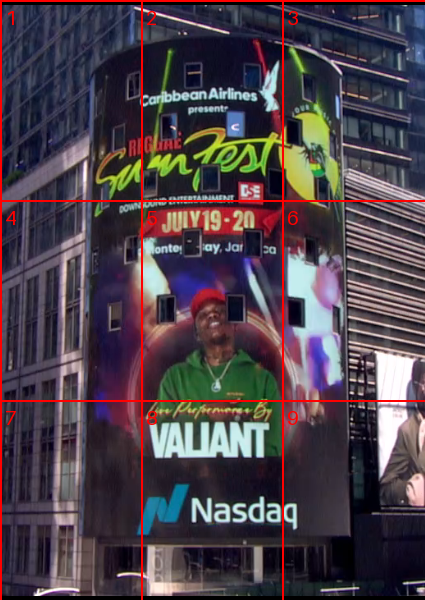

In [119]:
print(base64Urls[0])

In [7]:
prompt = """Here is a series of 10 frames from a video of a building with screen displaying video ads
Your role is to monitor the screen and analyze the ads and detect any defect.

the images have a grid with 16 sections drawn in red with the number of the grid in the upper left corner from 1 to 16.

These are example defects that can happen:
- one section of the screen stays static across the 10 frames
- all the screen stays static across the 10 frames

The building is in the middle of the picture it has windows and screens all around. Windows are always static.
Only analyze the building screen, ignore all the other parts of the image and all other buildings and signs.
There is a Nasdaq logo at the bottom of the screen, it is always static, don't consider it as an ad and don't include it in any text extraction.

Your role is to:
1. Analyze each grid section independently and for each of the section, tell me if there is movement across the 10 frames
2. Analyze the whole building and tell me if there is a defect affecting the whole screen
3. Identify the different video ads on the screen and summarize the content of each ad, who is it for and what is the main message.
4. Classify each frame into the ad displayed on the screen



Return a JSON with the following structure 
{"screen": {"defect":"Yes/No", "reason":"explain why you think there is a defect"},
"individual_sections":[{"number":1, "defect":"yes/no", "reason":"explain why you thinkt here is a defect"}],
"ads": [{"advertiser": "Name of the advertiser for the ad", "summary": "description of the ad"}, ...],
"frames": [{"frame_number":1,"description":"visual description of the screen", "advertiser": "Name of the advertiser for the ad", "text": "the text displayed on the ad"}, ...],

}

"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    response_format={ "type": "json_object" },
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
           *map(lambda x: {"type":"image_url", 
                           "image_url": {"url":x}, "resize": 768}, base64Urls[:10]),
        ],
      }
    ]
  )

print(response.choices[0].message.content)

{
  "screen": {
    "defect": "Yes",
    "reason": "The entire screen displays static content in the last two frames without any movement, indicating a potential defect."
  },
  "individual_sections": [
    {"number": 1, "defect": "no", "reason": "There is movement in this section across multiple frames."},
    {"number": 2, "defect": "no", "reason": "There is movement in this section across multiple frames."},
    {"number": 3, "defect": "no", "reason": "There is movement in this section across multiple frames."},
    {"number": 4, "defect": "no", "reason": "There is movement in this section across multiple frames."},
    {"number": 5, "defect": "no", "reason": "There is movement in this section across multiple frames."},
    {"number": 6, "defect": "no", "reason": "There is movement in this section across multiple frames."},
    {"number": 7, "defect": "no", "reason": "There is movement in this section across multiple frames."},
    {"number": 8, "defect": "no", "reason": "There is m

In [20]:
prompt = """Here is a series of 10 frames from a video of a building with screen displaying video ads
Your role is to monitor the screen and analyze the ads and detect any defect.

When a defect happens, all or part of the screen will go black or green.
A defect means a part of the screen is static for more than 5 consecutive frames.

The building is in the middle of the picture it has windows and screens all around. Windows are always static.
Only analyze the building screen, ignore all the other parts of the image and all other buildings and signs.

There is a Nasdaq logo at the bottom of the screen, it is always static, don't consider it as an ad and don't include it in any text extraction.

Perform the following actions to analyze the building screen in this order

1. Identify the different video ads on the screen and summarize the content of each ad, who is it for and what is the main message.
2. Classify each frame into the ad displayed on the screen
3. Extract the text displayed on each frame
4. Write a visual description of the screen content, describe all parts of the ad, the colors, characters etc
5. Identify if there is any defect during the sequence and explain your reasoning


Return the result in JSON format with the following structure:

{"ads": [{"advertiser": "Name of the advertiser for the ad", "summary": "description of the ad"}, ...],
"frames": [{"frame_number":1,"description":"visual description of the screen", "advertiser": "Name of the advertiser for the ad", "text": "the text displayed on the ad"}, ...],
"defect": {"detected": "True"/"False", "reason": "explanation of the defect if detected"}
}

"""

response = client.chat.completions.create(
    model="gpt-4o-global",
    response_format={ "type": "json_object" },
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
           *map(lambda x: {"type":"image_url", 
                           "image_url": {"url":x}, "resize": 768}, base64Urls[-10:]),
        ],
      }
    ]
  )

In [21]:
print(response.choices[0].message.content)

{
  "ads": [
    {
      "advertiser": "Australia Tourism",
      "summary": "An advertisement inviting people to 'Come and say G'Day' with imagery of a kangaroo and a scenic landscape."
    },
    {
      "advertiser": "Planet Fitness",
      "summary": "Advertisement promoting the convenience of their gym facilities, emphasizing 'The only gym that fits inside your carry-on'."
    },
    {
      "advertiser": "Unknown",
      "summary": "An ad with a colorful design featuring some abstract elements and bright colors but no clear messaging."
    }
  ],
  "frames": [
    {
      "frame_number": 1,
      "description": "A blue sky background with a kangaroo in the lower part of the screen. There is a big text 'G'Day' and the words 'Come and say' above it. The Nasdaq logo is at the bottom.",
      "advertiser": "Australia Tourism",
      "text": "COME AND SAY G'DAY"
    },
    {
      "frame_number": 2,
      "description": "The same blue sky background and kangaroo image with 'G'Day' tex

In [7]:
import ast
import pandas as pd

response_dict = ast.literal_eval(response.choices[0].message.content.replace('true','True'))
frames_df = pd.DataFrame(response_dict['frames'])


In [8]:
images_df = pd.DataFrame(base64Frames[-10:])
final_df = pd.concat([images_df, frames_df], axis=1)
final_df.head()

,file_name,base64_url,frame_number,advertiser,text
0,screenshot_20240628085418.png,"data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgA...",1,Ray-Ban,"HEY META, TAKE A PHOTO"
1,screenshot_20240628085421.png,"data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgA...",2,Ray-Ban,"HEY META, TAKE A PHOTO"
2,screenshot_20240628085424.png,"data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgA...",3,Ray-Ban,"HEY META, TAKE A PHOTO"
3,screenshot_20240628085426.png,"data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgA...",4,Ray-Ban,"HEY META, TAKE A PHOTO"
4,screenshot_20240628085429.png,"data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgA...",5,Ray-Ban,"HEY META, TAKE A PHOTO"


In [9]:
import pandas as pd

final_df['timestamp'] = pd.to_datetime(final_df['file_name'].str[11:-4], format='%Y%m%d%H%M%S')

In [10]:
final_df['defect_detected'] = response_dict['defect']['detected']
final_df['defect_detected'] = final_df['defect_detected'].map({'True': True, 'False': False})
final_df['defect_reason'] = response_dict['defect']['reason']

In [11]:
final_df['batch_id'] = final_df['timestamp'].min().strftime('%Y%m%d%H%M%S') + '_' + final_df['timestamp'].max().strftime('%Y%m%d%H%M%S')


In [12]:
response_dict['ads']

[{'advertiser': 'Ray-Ban',
  'summary': 'Promoting taking a photo with a Ray-Ban product collaboration with Meta.'},
 {'advertiser': 'Unknown',
  'summary': 'Promoting an anonymous ad or episode; unclear message.'}]

In [13]:
ads_df = pd.DataFrame(response_dict['ads'])
final_df = final_df.merge(ads_df, on='advertiser', how='left')


In [14]:
final_df[['timestamp','advertiser','summary','text','defect_detected','defect_reason','batch_id']]

,timestamp,advertiser,summary,text,defect_detected,defect_reason,batch_id
0,2024-06-28 08:54:18,Ray-Ban,Promoting taking a photo with a Ray-Ban produc...,"HEY META, TAKE A PHOTO",True,The screen content did not change for the firs...,20240628085418_20240628085443
1,2024-06-28 08:54:21,Ray-Ban,Promoting taking a photo with a Ray-Ban produc...,"HEY META, TAKE A PHOTO",True,The screen content did not change for the firs...,20240628085418_20240628085443
2,2024-06-28 08:54:24,Ray-Ban,Promoting taking a photo with a Ray-Ban produc...,"HEY META, TAKE A PHOTO",True,The screen content did not change for the firs...,20240628085418_20240628085443
3,2024-06-28 08:54:26,Ray-Ban,Promoting taking a photo with a Ray-Ban produc...,"HEY META, TAKE A PHOTO",True,The screen content did not change for the firs...,20240628085418_20240628085443
4,2024-06-28 08:54:29,Ray-Ban,Promoting taking a photo with a Ray-Ban produc...,"HEY META, TAKE A PHOTO",True,The screen content did not change for the firs...,20240628085418_20240628085443
5,2024-06-28 08:54:32,Unknown,Promoting an anonymous ad or episode; unclear ...,Indistinguishable visual content,True,The screen content did not change for the firs...,20240628085418_20240628085443
6,2024-06-28 08:54:35,Unknown,Promoting an anonymous ad or episode; unclear ...,Indistinguishable visual content,True,The screen content did not change for the firs...,20240628085418_20240628085443
7,2024-06-28 08:54:38,Unknown,Promoting an anonymous ad or episode; unclear ...,Indistinguishable visual content,True,The screen content did not change for the firs...,20240628085418_20240628085443
8,2024-06-28 08:54:40,Unknown,Promoting an anonymous ad or episode; unclear ...,Indistinguishable visual content,True,The screen content did not change for the firs...,20240628085418_20240628085443
9,2024-06-28 08:54:43,Unknown,Promoting an anonymous ad or episode; unclear ...,Indistinguishable visual content,True,The screen content did not change for the firs...,20240628085418_20240628085443
